## Primeiro bloco: Criando um conjunto de pontos que NÃO É linearmente separável

In [1]:
function circulo(
        r::Number, # raio do círculo de pontos
        σ::Number, # "quantidade de ruído"
        N::Integer # número de pontos a serem criados
    )
    ϕ = range(0; stop=2π, length=N) # dividir a circunferencia (360 graus) em N pedaços iguais
    rvec = r .+ σ * randn(N) # criar um conjunto de distâncias com ruído

    X = [rvec .* cos.(ϕ) rvec .* sin.(ϕ)] # X é uma matriz Nx2

    return permutedims(X) # permutedims(X) é uma matriz 2xN
end

r_classe_1, r_classe_2 = 2,4

σ = 0.1
N = 100

X1 = circulo(r_classe_1, σ, N)
X2 = circulo(r_classe_2, σ, N)

2×100 Matrix{Float64}:
 4.0924  4.06478   4.05803   3.85957   …   4.11249    3.95153    3.89213
 0.0     0.258324  0.517883  0.743872     -0.524832  -0.251127  -9.53297e-16

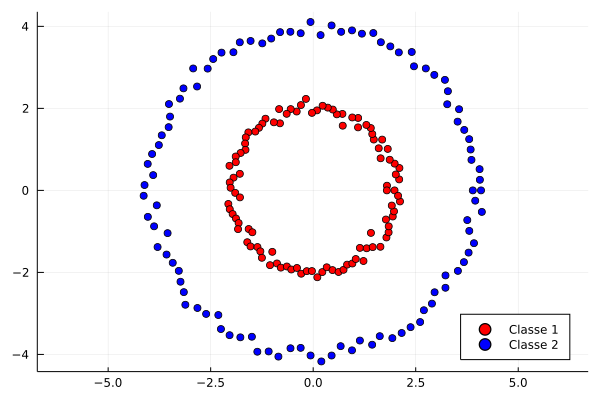

In [2]:
#Exibir os pontos...

using Plots
scatter2d(X::AbstractMatrix; kwargs...) = scatter(X[1, :], X[2, :]; kwargs...)
scatter2d!(X::AbstractMatrix; kwargs...) = scatter!(X[1, :], X[2, :]; kwargs...)

scatter2d(X1; color="red", label="Classe 1", aspectratio=:1.0)
scatter2d!(X2; color="blue", label="Classe 2", legend=:bottomright)

# Perceber que os dados NÃO SÃO LINEARMENTE SEPARÁVEIS

## Segundo bloco: estrutura da rede neural

In [3]:
linear(x) = x
d_linear(x) = 1.0

sigmoid(x) = 1 / (1 + exp(-x))
d_sigmoid(x) = sigmoid(x) * (1 - sigmoid(x))

#tanh(x) o julia ja sabe
d_tanh(x) = 1 - tanh(x)^2

function predict(x, w, b, f_a) 
    return sum(f_a.(w * x .+ b); dims=1)
end

predict (generic function with 1 method)

In [4]:
function computar_gradiente(X, Y, W, B, f_a, df_a)
    
    N_neurons, N_inputs = size(W) # como W é uma matriz, size(W) retorna (N_linhas, N_colunas))
    N_amostras = size(X,2) # como X é uma matriz, size(X, 2) retorna N_colunas)
    
    dW = zeros(N_neurons, N_inputs)
    dB = zeros(N_neurons)
    loss = 0.0

    for amostra in 1:N_amostras # para cada amostra
        
        erro = sum(f_a.(W * X[:, amostra] .+ B)) - Y[amostra] # o erro é a diferença entre o valor real e o valor obtido
                
        for neuron in 1:N_neurons # para cada neuron
            
            for input in 1:N_inputs # para cada input
                
                @views dW[neuron, input] += (2/N_amostras) * erro * df_a(W[neuron, :]' * X[:,amostra] + B[neuron]) * X[input,amostra]
                
            end # para cada input
            
            @views dB[neuron] += (2/N_amostras) * erro * df_a(W[neuron, :]' * X[:,amostra] + B[neuron])
            
        end # para cada neuron
        
        loss += 1/N_amostras * erro^2
        
    end #para cada amostra
    
    #println(dW)
    #println(dB)
    
    return dW, dB, loss
    
end

computar_gradiente (generic function with 1 method)

In [5]:
using Statistics: mean
using Plots

function treinar_rede_neural_0_comgrafico!(X, Y, w, b, f_a, df_a, mu, n_iters, grad_loss)

    loss = zeros(n_iters)
    acc = zeros(n_iters)
    
    for iteration in 1:n_iters
        
        Y_Predictions = predict(X, w, b, f_a)
        acc[iteration] = accuracy(w, b, X, Y, f_a)
        
        dW, dB, loss[iteration] = grad_loss(X, Y, w, b, f_a, df_a)
        
        w -= mu * dW
        b -= mu * dB
        
        loss_i = round(loss[iteration]; digits = 6)
        acc_i = round(acc[iteration]; digits = 6)
        
        # para plotar a "loss" ao longo das iterações...
        IJulia.clear_output(true)
        loss_plot = scatter(
            [1:10:iteration], loss[1:10:iteration];
            yscale=:log10,
            xlabel="iteration",
            ylabel="training loss",
            title="iteration $iteration, loss = $loss_i, accuracy = $acc_i"
            )
        display(loss_plot)
        
    end
    
    return(w, b, loss)
end

treinar_rede_neural_0_comgrafico! (generic function with 1 method)

In [6]:
X = hcat(X1, X2)

function criar_Y_sigmoid(X, X1)
    Y = Matrix{Int}(undef, 1, size(X, 2))
    for i in 1:size(X, 2)
        for j in 1:size(X1, 2)
            if X[i] == X1[j]
                Y[i] = 0
            end
        end
        if Y[i] != 0
            Y[i] = 1
        end
    end
    return Y
end
Y = criar_Y_sigmoid(X, X1)

1×200 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  1  1  1  1  1  1  1  1  1  1  1  1

In [16]:
w = rand(4,2)
b = rand(4)

4-element Vector{Float64}:
 0.23204905549712973
 0.6316363164156888
 0.1374604301001101
 0.46785291136435947

In [8]:
mu = 0.1
n_iters = 1000

1000

In [9]:
function accuracy(w, b, X, Y, f_a)
    Y_Predictions = predict(X, w, b, f_a)
    acc = mean([ el > 0.5 ? 1 : 0 for el in Y_Predictions ] .== Y)
    return(acc)
end

accuracy (generic function with 1 method)

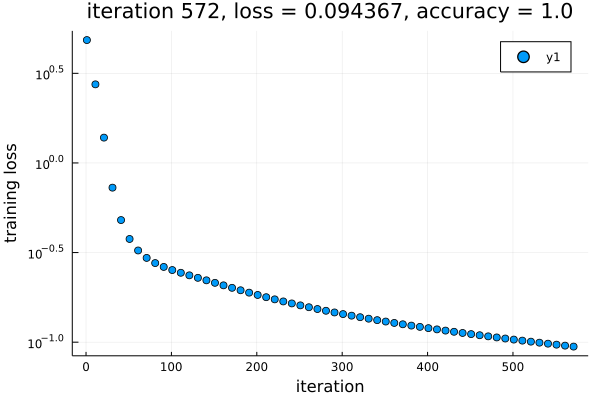

LoadError: InterruptException:

In [17]:
w, b, loss = treinar_rede_neural_0_comgrafico!(X, Y, w, b, sigmoid, d_sigmoid, mu, n_iters, computar_gradiente)

In [197]:
accuracy(w, b, X, Y, sigmoid)

0.5

In [26]:
N = 10
m = hcat(circulo(4, σ, N), circulo(2, σ, N))
y_teste = hcat(transpose(zeros(10)), transpose(ones(10)))

1×20 transpose(::Vector{Float64}) with eltype Float64:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [22]:
Y_p = predict(m, w, b, sigmoid)

1×20 Matrix{Float64}:
 3.68736  3.77844  3.48328  2.52122  0.921287  …  0.916456  3.17678  3.95491

In [27]:
accuracy(w, b, m, y_teste, sigmoid)

0.6